# [RSNA Screening Mammography Breast Cancer Detection](https://www.kaggle.com/c/petfinder-pawpularity-score)
> Find breast cancers in screening mammograms

![](https://storage.googleapis.com/kaggle-competitions/kaggle/39272/logos/header.png?t=2022-11-28-17-29-35)

# Idea:
* In this notebook will do inference for `breast cancer` detection from Mammography images.
* Dicom images are saved to `1024` dim with aspect ratio. Modify `resize_dim` and `aspect_ratio` in config file to change them.
* Batch Size is chosen adaptly depending on the image_size, you can change it on the `inference` cell
* You can play with notebook by simply changing `tta` and `thr` parameter in config.

# Notebooks
* Only Image:
    * ROI:
        * train: [RSNA-BCD: EfficientNet [TF][TPU-1VM][Train]](https://www.kaggle.com/code/awsaf49/rsna-bcd-efficientnet-tf-tpu-1vm-train)
        * infer: [RSNA-BCD: EfficientNet [TF][TPU-1VM][Infer]](https://www.kaggle.com/code/awsaf49/rsna-bcd-efficientnet-tf-tpu-1vm-infer)
    * NoROI + KerasCV: 
        * train: [RSNA-BCD: NoROI KerasCV [TF][Train]](https://www.kaggle.com/awsaf49/rsna-bcd-noroi-kerascv-tf-train/)
        * infer: [RSNA-BCD: NoROI KerasCV [TF][Infer]](https://www.kaggle.com/awsaf49/rsna-bcd-noroi-kerascv-tf-infer/)
* Dataset:
    * ROI:
        * [RSNA-BCD: ROI 1024x PNG Dataset](https://www.kaggle.com/datasets/awsaf49/rsna-bcd-roi-1024x-png-dataset)
    * NoROI:
        * [RSNA-BCD: 512 PNG v2 PNG Dataset](https://www.kaggle.com/datasets/awsaf49/rsnabcd-512-png-v2-dataset)

# Update:
* `v9` - `09/12/2022`:
    * train_notebook: `v10` | img_size: 1024x512 | thr=0.60 | folds=0,1
* `v10` - `10/12/2022`:
    * same as `v9` uses **3folds** + **flip-model**
* `v15` - `11/12/2022`:
    * v2-fix data used
* `v16` - `11/12/2022`:
    * low lr
* `v17` - `13/12/2022`:
    * high res - 2048 x 1024 , single fold

# Install Libraries

In [1]:
!pip install -q /kaggle/input/rsna-bcd-whl-ds/python_gdcm-3.0.20-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q /kaggle/input/rsna-bcd-whl-ds/pylibjpeg-1.4.0-py3-none-any.whl
!pip install -q /kaggle/input/rsna-bcd-whl-ds/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
!cp -r /kaggle/input/efficientnet-keras-dataset/efficientnet_kaggle /tmp/ && pip install -q /tmp/efficientnet_kaggle

# Import Libraries

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to avoid too many logging messages
import pandas as pd, numpy as np, random, shutil
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import yaml

from IPython import display as ipd
from glob import glob
from tqdm import tqdm

# Version Check

In [3]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('tf:',tf.__version__)
print('tfa:', tfa.__version__)

np: 1.21.6
pd: 1.3.5
sklearn: 1.0.2
tf: 2.6.4
tfa: 0.14.0


# Configuration

In [4]:
class CFG:
    debug         = False
    
    # use verbose=0 for silent, vebose=1 for interactive,
    verbose      = 1 if debug else 0
    
    # device
    device = "GPU" # or "GPU"

    # seed for data-split, layer init, augs
    seed = 42
    
    # which folds of ckpt to use
    num_folds = 1

    # dicom to png size
    resize_dim = 2048
    aspect_ratio = True
    
    # size of training image
    img_size = [2048, 1024]

    # augmentation
    augment   = True

    # scale-shift-rotate-shear
    transform = False
    fill_mode = 'constant'
    rot    = 2.0
    shr    = 2.0
    hzoom  = 50.0
    wzoom  = 50.0
    hshift = 10.0
    wshift = 10.0

    # flip
    hflip = False
    vflip = False

    # clip
    clip = False

    # lr-scheduler
    scheduler   = 'exp' # cosine

    # dropout
    drop_prob   = 0.0
    drop_cnt    = 10
    drop_size   = 0.08

    # pixel-augment
    pixel_aug = False
    sat  = [0.7, 1.3]
    cont = [0.8, 1.2]
    bri  = 0.15
    hue  = 0.05

    # threshold
    thr = 0.70
    
    # test-time augs
    flip_model = False
    tta = 1
    
    # target column
    target_col  = ['cancer']

# Reproducibility

In [5]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


# Device Configs
This notebook is compatible for **remote-tpu**, **local-tpu**, **multi-gpu** and **single-gpu**. Simple change to `device="TPU"` for **remote-tpu** and `device="TPU-1VM"` for **local-tpu** and finally, `device="GPU"` for single or multi-gpu.

In [6]:
if "TPU" in CFG.device:
    tpu = 'local' if CFG.device=='TPU-1VM' else None
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    except:
        CFG.device = "GPU"
        
if CFG.device == "GPU"  or CFG.device=="CPU":
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    if ngpu>1:
        print("Using multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    elif ngpu==1:
        print("Using single GPU")
        strategy = tf.distribute.get_strategy()
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        CFG.device = "CPU"

if CFG.device == "GPU":
    print("Num GPUs Available: ", ngpu)
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using single GPU
Num GPUs Available:  1
REPLICAS: 1


# Meta Data

In [7]:
BASE_PATH = '/kaggle/input/rsna-breast-cancer-detection'
IMG_DIR = '/tmp/dataset/rsna-bcd'

In [8]:
# train
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['dicom_path'] = f'{BASE_PATH}/train_images'\
                    + '/' + df.patient_id.astype(str)\
                    + '/' + df.image_id.astype(str)\
                    + '.dcm'
df['image_path'] = df.dicom_path.str.replace('.dcm','.png').str.replace(BASE_PATH, IMG_DIR)
print('Train:')
display(df.head(2))

# test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['dicom_path'] = f'{BASE_PATH}/test_images'\
                    + '/' + test_df.patient_id.astype(str)\
                    + '/' + test_df.image_id.astype(str)\
                    + '.dcm'
test_df['image_path'] = test_df.dicom_path.str.replace('.dcm','.png').str.replace(BASE_PATH, IMG_DIR)
print('\nTest:')
display(test_df.head(2))

Train:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,dicom_path,image_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,/tmp/dataset/rsna-bcd/train_images/10006/46282...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,/tmp/dataset/rsna-bcd/train_images/10006/14595...



Test:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()


,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,dicom_path,image_path
0,2,10008,736471439,L,MLO,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/tes...,/tmp/dataset/rsna-bcd/test_images/10008/736471...
1,2,10008,1591370361,L,CC,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/tes...,/tmp/dataset/rsna-bcd/test_images/10008/159137...


# Check If Data Exist?

In [9]:
tf.io.gfile.exists(df.dicom_path.iloc[0]), tf.io.gfile.exists(test_df.dicom_path.iloc[0])

(True, True)

## Train-Test Ditribution

In [10]:
print('train_files:',df.shape[0])
print('test_files:',test_df.shape[0])

train_files: 54706
test_files: 4


# DICOM to PNG

## Create Directory

In [11]:
!rm -r /tmp/Dataset/rsna-bcd
os.makedirs('/tmp/dataset/rsna-bcd/train_images', exist_ok = True)
os.makedirs('/tmp/dataset/rsna-bcd/test_images', exist_ok = True)

rm: cannot remove '/tmp/Dataset/rsna-bcd': No such file or directory


## ROI Utils

In [12]:
import cv2

def img2roi(img):
    # Binarize the image
    bin_img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]

    # Make contours around the binarized image, keep only the largest contour
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)

    # Find ROI from largest contour
    ys = contour.squeeze()[:, 0]
    xs = contour.squeeze()[:, 1]
    roi =  img[np.min(xs):np.max(xs), np.min(ys):np.max(ys)]
    
    return roi

## Dicom Utils

In [13]:
# import pydicom
# from pydicom.pixel_data_handlers.util import apply_voi_lut


import dicomsdl


def read_xray(path, fix_monochrome = True):
    dicom = dicomsdl.open(path)
    data = dicom.pixelData(storedvalue=False)  # storedvalue = True for int16 return otherwise float32
    data = data - np.min(data)
    data = data / np.max(data)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    return data

def resize_and_save(file_path):
    img = read_xray(file_path)
    h, w = img.shape[:2]  # orig hw
    if CFG.aspect_ratio:
        r = CFG.resize_dim / max(h, w)  # resize image to img_size
        interp = cv2.INTER_LINEAR
        if r != 1:  # always resize down, only resize up if training with augmentation
            img = cv2.resize(img, (int(w * r), int(h * r)), interpolation=interp)
    else:
        img = cv2.resize(img, (CFG.resize_dim, CFG.resize_dim), cv2.INTER_LINEAR)
    
    img = (img * 255).astype(np.uint8)
    img = img2roi(img)
    img = cv2.resize(img, CFG.img_size[::-1], cv2.INTER_LINEAR)
    
    sub_path = file_path.split("/",4)[-1].split('.dcm')[0] + '.png'
    infos = sub_path.split('/')
    pid = infos[-2]
    iid = infos[-1]; iid = iid.replace('.png','')
    new_path = os.path.join(IMG_DIR, sub_path)
    os.makedirs(new_path.rsplit('/',1)[0], exist_ok=True)
    cv2.imwrite(new_path, img)
    return pid,iid,w,h

## Conversion

In [14]:
%%time
from joblib import Parallel, delayed
file_paths = test_df.dicom_path.tolist()
imgsize = Parallel(n_jobs=2,backend='threading')(delayed(resize_and_save)(file_path)\
                                                  for file_path in tqdm(file_paths, leave=True, position=0))

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

CPU times: user 2.7 s, sys: 104 ms, total: 2.8 s
Wall time: 2.99 s


# Data Augmentation
Used simple augmentations, some of them may hurt the model.
* RandomFlip (Left-Right)
* No Rotation
* RandomBrightness
* RndomContrast
* Shear
* Zoom
* Coarsee Dropout/Cutout

In [15]:
def get_mat(shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    #rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
#     c1   = tf.math.cos(rotation)
#     s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
#     rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
#                                    -s1,  c1,   zero, 
#                                    zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                               zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    

    return  K.dot(shear_matrix,K.dot(zoom_matrix, shift_matrix)) #K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))                  

def transform(image, DIM=CFG.img_size):#[rot,shr,h_zoom,w_zoom,h_shift,w_shift]):
    if DIM[0]>DIM[1]:
        diff  = (DIM[0]-DIM[1])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]],[0, 0]])
        NEW_DIM = DIM[0]
    elif DIM[0]<DIM[1]:
        diff  = (DIM[1]-DIM[0])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0],[0, 0]])
        NEW_DIM = DIM[1]
    
    rot = CFG.rot * tf.random.normal([1], dtype='float32')
    shr = CFG.shr * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / CFG.hzoom
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / CFG.wzoom
    h_shift = CFG.hshift * tf.random.normal([1], dtype='float32') 
    w_shift = CFG.wshift * tf.random.normal([1], dtype='float32') 
    
    transformation_matrix=tf.linalg.inv(get_mat(shr,h_zoom,w_zoom,h_shift,w_shift))
    
    flat_tensor=tfa.image.transform_ops.matrices_to_flat_transforms(transformation_matrix)
    
    image=tfa.image.transform(image,flat_tensor, fill_mode=CFG.fill_mode)
    
    rotation = math.pi * rot / 180.
    
    image=tfa.image.rotate(image,-rotation, fill_mode=CFG.fill_mode)
    
    if DIM[0]>DIM[1]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[:, pad[0]:-pad[1],:]
    elif DIM[1]>DIM[0]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[pad[0]:-pad[1],:,:]
    image = tf.reshape(image, [*DIM, 3])    
    return image

def dropout(image,DIM=CFG.img_size, PROBABILITY = 0.6, CT = 5, SZ = 0.1):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): 
        return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM[0],y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM[1],x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) 
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,3])

#     image = tf.reshape(image,[*DIM,3])
    return image

## Data Pipeline
* Reads the raw file and then decodes it to tf.Tensor
* Resizes the image in desired size
* Chages the datatype to **float32**
* Caches the Data for boosting up the speed.
* Uses Augmentations to reduce overfitting and make model more robust.
* Finally, splits the data into batches.


In [16]:
def build_decoder(with_labels=True, target_size=CFG.img_size, ext='png'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

#         img = tf.image.resize(img, target_size)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*target_size, 3])

        return img
    
    def decode_with_labels(path, label):
        return decode(path), tf.cast(label, tf.float32)
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True, dim=CFG.img_size):
    def augment(img, dim=dim):
        img = transform(img,DIM=dim) if CFG.transform else img
        img = tf.image.random_flip_left_right(img) if CFG.hflip else img
        img = tf.image.random_flip_up_down(img) if CFG.vflip else img
        if CFG.pixel_aug:
            img = tf.image.random_hue(img, CFG.hue)
            img = tf.image.random_saturation(img, CFG.sat[0], CFG.sat[1])
            img = tf.image.random_contrast(img, CFG.cont[0], CFG.cont[1])
            img = tf.image.random_brightness(img, CFG.bri)
        img = dropout(img, DIM=dim, PROBABILITY = CFG.drop_prob, CT = CFG.drop_cnt, SZ = CFG.drop_size)
        img = tf.clip_by_value(img, 0, 1)  if CFG.clip else img         
        img = tf.reshape(img, [*dim, 3])
        return img
    
    def augment_with_labels(img, label):    
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

## Visualization
* Check if augmentation is working properly or not.

In [17]:
def display_batch(batch, size=2):
    imgs = batch
    plt.figure(figsize=(size*2, 10))
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        plt.imshow(imgs[img_idx,:, :, :])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show() 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


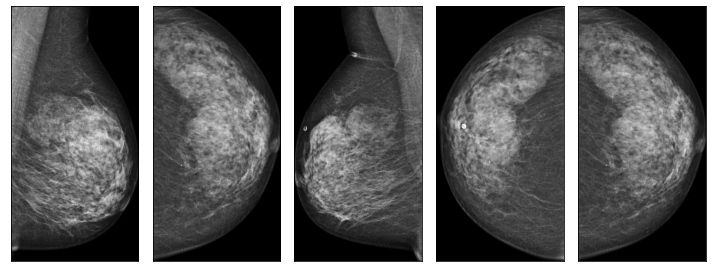

In [18]:
fold = 0
fold_df = test_df.copy()
paths  = fold_df.image_path.tolist()
labels = None
ds = build_dataset(paths, labels, cache=False, batch_size=32,
                   repeat=True, shuffle=True, augment=True)
ds = ds.unbatch().batch(20)
batch = next(iter(ds))
display_batch(batch, 5);

# Model Configs

In [19]:
CKPT_DIRS = [
    ([2048, 1024], '/kaggle/input/rsnabcd-efficientnet-tftpu1vmtrain-ds'),
]

MODEL_CONFIGS = []
for img_size, ckpt_dir in  CKPT_DIRS:
    paths = sorted(glob(os.path.join(ckpt_dir, '*h5')))[0:CFG.num_folds]
    if len(paths)==0:
        print('no model found for :',base_dir)
    MODEL_CONFIGS.append([img_size, paths])
display(MODEL_CONFIGS)

[[[2048, 1024],
  ['/kaggle/input/rsnabcd-efficientnet-tftpu1vmtrain-ds/fold-0.h5']]]

# Flip Model

> Takes more GPU but less time with more deterministic result than tta

In [20]:
def build_flip_model(model_path):
    base = tf.keras.models.load_model(model_path, compile=False)
    inp1 = base.input
    inp2 = tf.keras.layers.Lambda(lambda x: tf.image.flip_left_right(x), name='flip')(inp1)
    out1 = base(inp1)
    out2 = base(inp2)
    out = tf.keras.layers.Average(name='ensemble')([out1, out2])
    model = tf.keras.models.Model(inp1, out)
    return model

# Inference

In [21]:
print('='*35)
print('### Predicting')
print('='*35)
preds=[]
for idx, (img_size, model_paths) in enumerate(MODEL_CONFIGS):
    dim = np.prod(img_size)**0.5
    test_paths = test_df.image_path.tolist()
    if len(test_paths)<=4:
        CFG.batch_size = 1
    elif dim>=1024:
        CFG.batch_size = REPLICAS * int(4 * 2)
    elif dim>=768:
        CFG.batch_size = REPLICAS * int(16 * 2)
    elif dim>=640:
        CFG.batch_size = REPLICAS * int(28 * 2)
    else:
        CFG.batch_size = REPLICAS * int(32 * 2)
    dtest = build_dataset(
        test_paths, 
        batch_size=CFG.batch_size, repeat=True, 
        shuffle=False, augment=CFG.tta>1, cache=False,
        decode_fn=build_decoder(with_labels=False, target_size=img_size),
        augment_fn=build_augmenter(with_labels=False, dim=img_size)
    )
    print(f'Model {idx:02d}:')
    for model_path in model_paths:
        with strategy.scope():
            print('Loading Model...')
            if CFG.flip_model:
                model = build_flip_model(model_path)
            else:
                model = tf.keras.models.load_model(model_path, compile=False)
        print('Predicting...');
        pred = model.predict(dtest, steps = CFG.tta*len(test_paths)/CFG.batch_size, verbose=1)
        pred = pred[:CFG.tta*len(test_paths),:]
        pred = np.mean(pred.reshape(CFG.tta, len(test_paths), -1), axis=0)
        preds.append(pred)
        print()
preds = np.mean(preds, axis=0)

### Predicting
Model 00:
Loading Model...
Predicting...


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 9s 96ms/step


Cleanup called...
Cleanup called...
Cleanup called...


# Submission

In [22]:
pred_df = pd.DataFrame({'prediction_id':test_df.prediction_id,
                        'cancer':preds.reshape(-1)})
sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
del sub_df['cancer']
sub_df = sub_df.merge(pred_df, on='prediction_id', how='left')
sub_df = sub_df.groupby('prediction_id')['cancer'].max().reset_index()  # merge duplicate prediction_id
sub_df['cancer'] = (sub_df.cancer>CFG.thr).astype('float32') # thresholding
sub_df.to_csv('submission.csv',index=False)
sub_df.head()

,prediction_id,cancer
0,10008_L,0.0
1,10008_R,0.0
